แนวคิดจาก https://www.kaggle.com/code/balajivaraprasad/introvert-0-976518-ann-xgb-knn-lr-ens/notebook

Data set from :

https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/data

https://www.kaggle.com/competitions/playground-series-s5e7/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')

In [ ]:
original_path = '/content/drive/MyDrive/dataset/Introvert From Extrovert/personality_dataset.csv'
train_path = '/content/drive/MyDrive/dataset/Introvert From Extrovert/train.csv'
test_path = '/content/drive/MyDrive/dataset/Introvert From Extrovert/test.csv'

original = pd.read_csv(original_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# EDA

In [ ]:
train.shape, test.shape

((18524, 9), (6175, 8))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [ ]:
cols = train.columns #ดู Cols ใน train
vals_na = train.isna().sum()
percent = train.isna().sum() / train.shape[0] * 100
pd.DataFrame({'vals_na': vals_na, 'percent': percent})

,vals_na,percent
id,0,0.000000
Time_spent_Alone,1190,6.424098
Stage_fear,1893,10.219175
Social_event_attendance,1180,6.370114
Going_outside,1466,7.914057
Drained_after_socializing,1149,6.202764
Friends_circle_size,1054,5.689916
Post_frequency,1264,6.823580
Personality,0,0.000000


In [ ]:
cols = test.columns #ดู Cols ใน test
vals_na = test.isna().sum()
percent = test.isna().sum() / test.shape[0] * 100
pd.DataFrame({'vals_na': vals_na, 'percent': percent})

,vals_na,percent
id,0,0.000000
Time_spent_Alone,425,6.882591
Stage_fear,598,9.684211
Social_event_attendance,397,6.429150
Going_outside,466,7.546559
Drained_after_socializing,432,6.995951
Friends_circle_size,350,5.668016
Post_frequency,408,6.607287


## ทดลอง Drop Missing Values ทั้งหมด

In [ ]:
# train.dropna(inplace = True)
# test.dropna(inplace = True)
# train.shape, test.shape

The missing data percantage is small, but if remove each with missing values. we're losing 45% of data


Actual Train & Test\
((18524, 9), (6175, 8))


After dropped missing value\
((10189, 9), (3397, 8))


## Fill Missing Values

In [ ]:
numeric_cols = train.select_dtypes(include='float64').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id']

cat_cols = train.select_dtypes(include='object').columns.tolist()


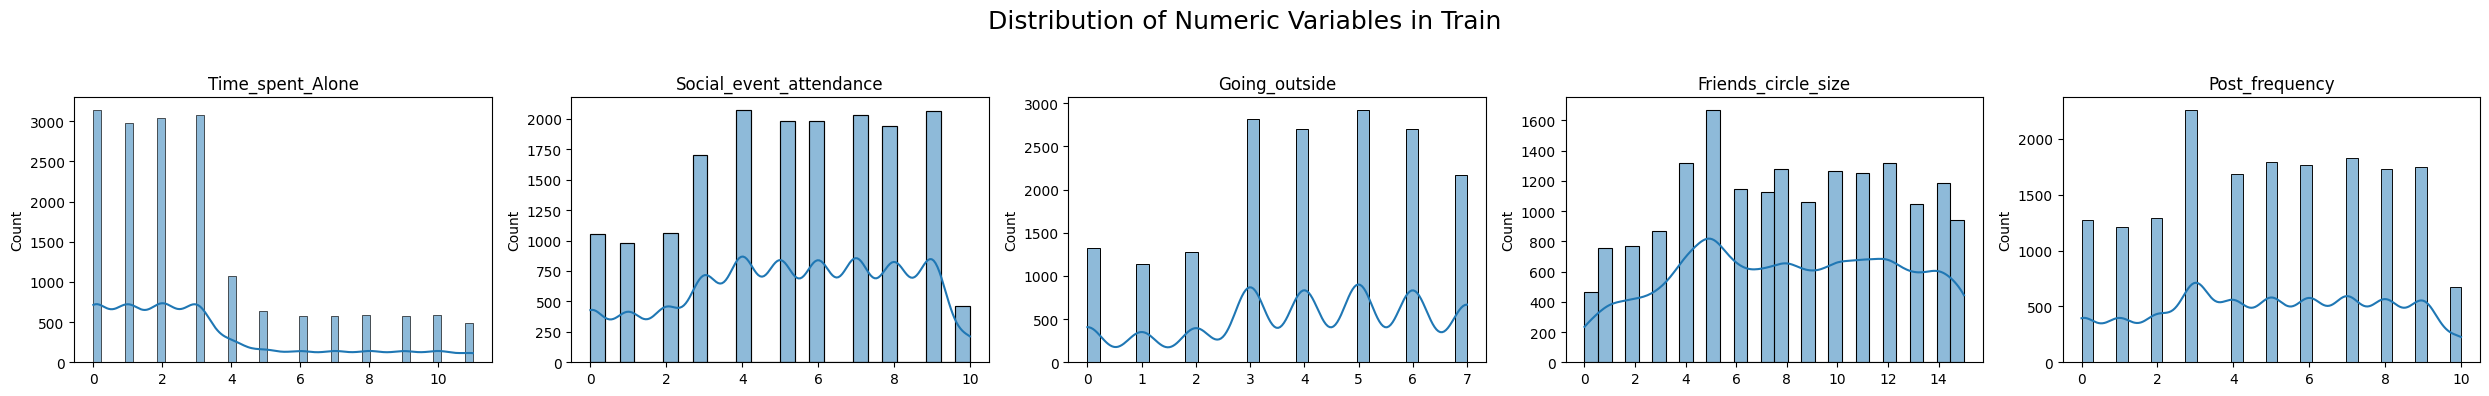

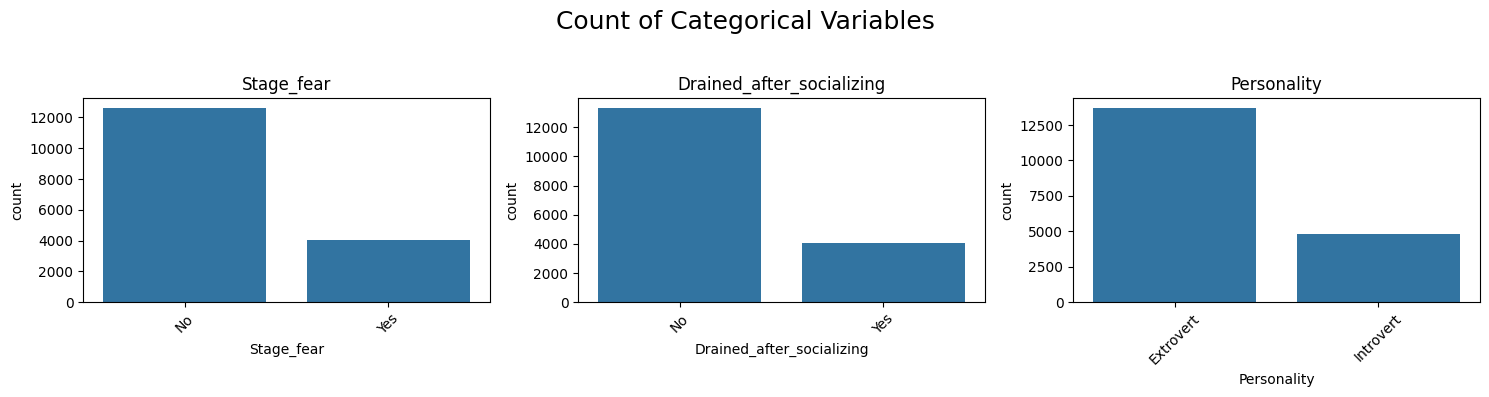

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(5*len(numeric_cols), 4))
fig.suptitle('Distribution of Numeric Variables in Train', fontsize=18)

for i, col in enumerate(numeric_cols):
    sns.histplot(train[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# วาดหมวดหมู่
fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(5*len(cat_cols), 4))
fig.suptitle('Count of Categorical Variables', fontsize=18)

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

After examining the Personality column, which is the target variable, I found that the dataset is imbalanced.

In [ ]:
numeric_cols = test.select_dtypes(include='float64').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'id']

cat_cols = test.select_dtypes(include='object').columns.tolist()


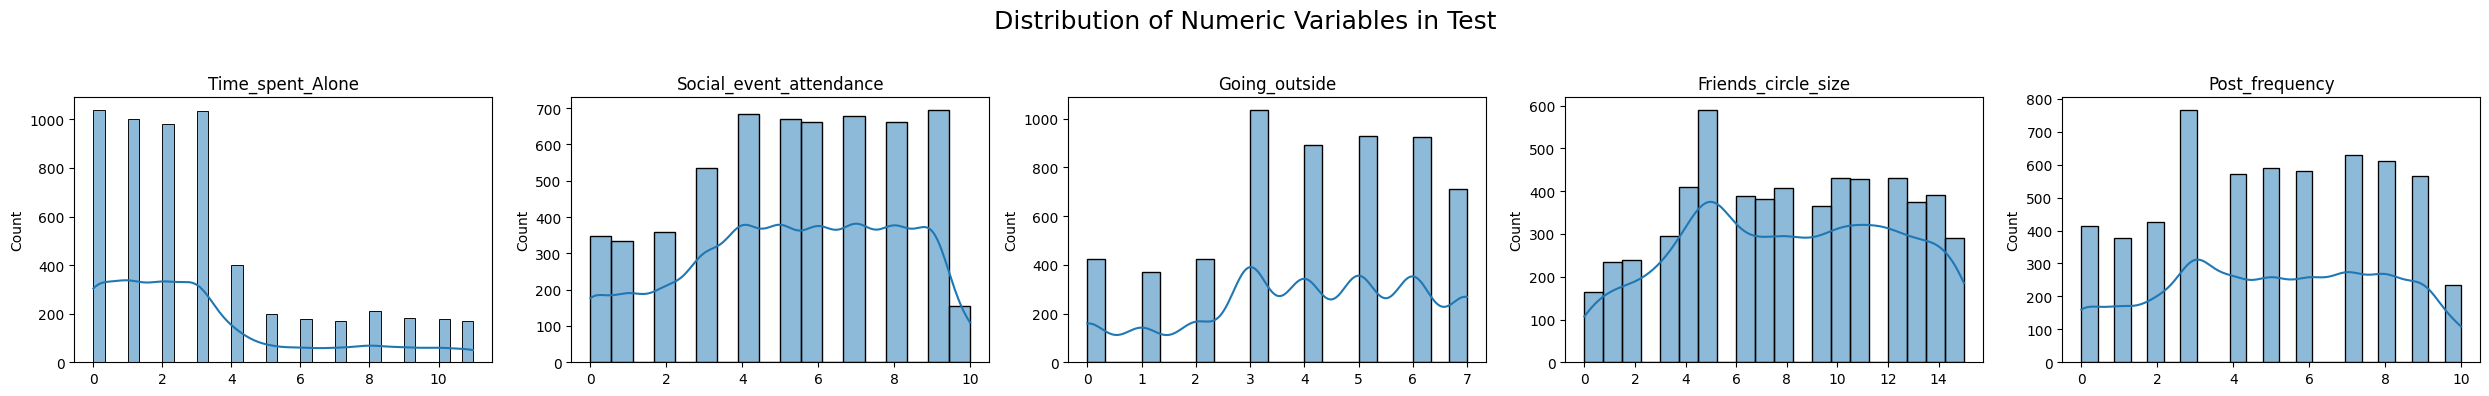

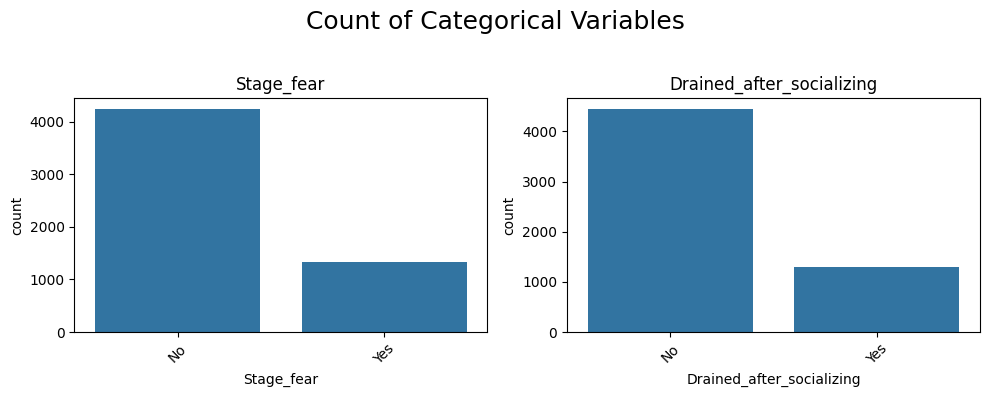

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(5*len(numeric_cols), 4))
fig.suptitle('Distribution of Numeric Variables in Test', fontsize=18)

for i, col in enumerate(numeric_cols):
    sns.histplot(test[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# วาดหมวดหมู่
fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(5*len(cat_cols), 4))
fig.suptitle('Count of Categorical Variables', fontsize=18)

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=test, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()

train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols]  = test[num_cols].fillna(test[num_cols].median())


In [ ]:
train['Stage_fear'] = train['Stage_fear'].map({'Yes': 1, 'No':0})
test['Stage_fear'] = test['Stage_fear'].map({'Yes': 1, "No": 0})

train['Drained_after_socializing'] = train['Drained_after_socializing'].map({'Yes': 1, "No": 0})
test['Drained_after_socializing'] = test['Drained_after_socializing'].map({'Yes': 1, "No": 0})

train['Personality'] = train['Personality'].map({'Extrovert': 0, 'Introvert': 1})

In [ ]:
cat_cols = ['Drained_after_socializing', 'Stage_fear', 'Personality']

train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode(dropna=True).iloc[0])

cat_cols = [c for c in cat_cols if c != 'Personality']
test[cat_cols] = test[cat_cols].fillna(train[cat_cols].mode(dropna=True).iloc[0])


# Train and Test

In [ ]:
X = train.drop(train.columns[-1], axis = 1)
y = train[train.columns[-1]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression


Logistic Regression สามารถใช้ได้กับ imbalance dataset เพราะว่าเราสามารถปรับ weight ใน loss fucntion เพื่อให้โมเดล “ลงโทษ” การทายผิดในคลาสน้อยมากกว่าคลาสมาก

In [ ]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
pred = lr.predict(X_test)

In [ ]:
print("Logistic Regression Accuracy : ", accuracy_score(pred, y_test))

Logistic Regression Accuracy :  0.968421052631579


In [ ]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

train_score = f1_score(y_train, y_pred_train, average='macro')
test_score  = f1_score(y_test, y_pred_test, average='macro')

print("Train F1:", train_score)
print("Test F1:", test_score)

gap = train_score - test_score
if gap > 0.1:  # เกณฑ์พอประมาณ
    print("⚠️ Possible Overfitting")

Train F1: 0.9581512173414332
Test F1: 0.9585505520521247


# XGBoost

Lib Optuna จะสามารถกำหนดช่วงการสุ่มค่าได้ เพื่อให้โมเดลได้ลองหลายค่าแล้วหาอันที่ทำให้โมเดล Perform ดีที่สุด

In [ ]:
X_train_split, X_valid, y_train_split, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

def objective(trial):
  params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "objective": "binary:logistic",
        "tree_method": "hist",
        "eval_metric": "aucpr",
        "random_state": 42,
        "early_stopping_rounds" : 50
  }
  model = XGBClassifier(**params)

  model.fit(
      X_train_split, y_train_split,
      eval_set=[(X_valid, y_valid)],
      verbose=False
  )

  preds = model.predict(X_valid)
  score = f1_score(y_valid, preds, average='macro')
  return score

# รันหา best params
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-08-12 09:43:04,320] A new study created in memory with name: no-name-587b5048-7f7f-4bbb-ac27-d519b4b91a50
[I 2025-08-12 09:43:04,513] Trial 0 finished with value: 0.9626047086551797 and parameters: {'n_estimators': 1774, 'max_depth': 7, 'learning_rate': 0.1808598600343303, 'subsample': 0.8571604945605349, 'colsample_bytree': 0.8632395599767421, 'min_child_weight': 5, 'gamma': 2.0176253087285536}. Best is trial 0 with value: 0.9626047086551797.
[I 2025-08-12 09:43:04,638] Trial 1 finished with value: 0.9622678018575852 and parameters: {'n_estimators': 904, 'max_depth': 9, 'learning_rate': 0.20184602576024066, 'subsample': 0.8645483995753249, 'colsample_bytree': 0.7515620902135596, 'min_child_weight': 2, 'gamma': 3.532767799944241}. Best is trial 0 with value: 0.9626047086551797.
[I 2025-08-12 09:43:04,765] Trial 2 finished with value: 0.9629418332190943 and parameters: {'n_estimators': 1721, 'max_depth': 8, 'learning_rate': 0.1918516541320781, 'subsample': 0.6646416862363654, 'c

Best params: {'n_estimators': 938, 'max_depth': 6, 'learning_rate': 0.05180020876407283, 'subsample': 0.6977298096310854, 'colsample_bytree': 0.8063726075025472, 'min_child_weight': 9, 'gamma': 4.997019920710057}
Best score: 0.963303686063494


In [ ]:
model = model = XGBClassifier(
    n_estimators = 606,
    max_depth = 5,
    learning_rate = 0.11873727480308,
    subsample = 0.8117977954031834,
    colsample_bytree = 0.6770490801276856,
    min_child_weight = 6,
    gamma = 1.179918341312779
)

model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_valid, y_valid)],
    verbose=False
    )

preds = model.predict(X_valid)
score = f1_score(y_valid, preds, average='macro')

In [ ]:
print("XGB Accuracy:", accuracy_score(y_valid, preds))

XGB Accuracy: 0.9708502024291498


In [ ]:
out = pd.DataFrame({
    'id' : test['id'],
    'Personality' : model.predict(test)
})

out['Personality'] = out['Personality'].map({1: 'Introvert', 0: 'Extrovert'})


In [ ]:
out

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
...,...,...
6170,24694,Extrovert
6171,24695,Introvert
6172,24696,Extrovert
6173,24697,Extrovert


In [ ]:
out.to_csv('/content/drive/MyDrive/dataset/Introvert From Extrovert/personality_predictions.csv', index=False)
print('Saved: personality_predictions.csv')

Saved: personality_predictions.csv


# KNN

In [ ]:
# Elbows Method
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_values = list(range(1, 20))
accuracy_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    # ใช้ cross-validation 5-fold เพื่อความแม่นยำ
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())
    print(f"Mean CV Accuracy for k={k}: {scores.mean():.4f}")

plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.title('Elbow Method for KNN')
plt.show()

In [ ]:
k = 9
knn = KNeighborsClassifier(
    n_neighbors=k
)

knn.fit(X_train_scaled, y_train)

In [ ]:
y_pred = knn.predict(X_test)
print("KNN Acuracy :", accuracy_score(y_test, y_pred))